In [1]:
!which pip

/data/serrano/miniconda3/wisp/bin/pip


In [2]:
import airfrans as af
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

In [4]:
import numpy as np

In [5]:
import torch

In [6]:
key_to_index = {
    "x": 0,
    "y": 1,
    "inlet_x": 2,
    "inlet_y": 3,
    "sdf": 4,
    "nx": 5,
    "ny": 6,
    "vx": 7,
    "vy": 8,
    "p": 9,
    "nu":10,
}

In [7]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/INR_domain_decomposition/")

from src.data.dataset import GeometryDatasetFull, KEY_TO_INDEX, load_inr, load_modulations
from src.models.pointnet_2 import PointNet2
from torch_geometric.loader import DataLoader

import einops
import json
import numpy as np
import torch
import torch.nn as nn
from graph_metalearning import outer_step
import yaml
from omegaconf import DictConfig

In [8]:
from experiments.inr import ModulatedPositionalEmbedder, PositionalEmbedder2

/home/serrano/Projects/INR_domain_decomposition/experiments/inr.py:146: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="basic.yaml")


In [9]:
from experiments.inr_sdf import ModulatedPositionalEmbedder as ModulatedPositionalEmbedderSDF

/home/serrano/Projects/INR_domain_decomposition/experiments/inr_sdf.py:136: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="basic.yaml")


# 1. Load pressure results

In [17]:
task = "full"
data_to_encode = None
latent_dim = 256
scale_factor=1

In [19]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

trainset = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
#n = int(.9*len(manifest_train))

#print("len manifest train", manifest_train, n)

#trainset = manifest_train[:n] # was [:-n] ???

ntrain = len(trainset)
nval = len(valset)

#default sample is none
trainset = GeometryDatasetFull(trainset, key=data_to_encode, latent_dim=latent_dim, scale_factor=scale_factor, norm=True, sample='mesh', n_boot=8000)
print("loaded train")
testset = GeometryDatasetFull(testset, key=data_to_encode, latent_dim=latent_dim, scale_factor=scale_factor, sample='mesh', n_boot=8000, coef_norm=trainset.coef_norm)
    

data_dir /data/serrano/airfrans/


100%|████████████████████████████████████████████████████████████████| 800/800 [03:43<00:00,  3.58it/s]


coef_norm (array([ 5.0064105e-01,  1.1181436e-02,  6.1606461e+01,  4.8862386e+00,
        2.3173042e-01, -1.6572434e-03, -8.5309672e-05], dtype=float32), array([ 0.7040743 ,  0.33643225, 17.757267  ,  6.2838936 ,  0.47521183,
        0.04159059,  0.06237248], dtype=float32), array([ 4.2485832e+01,  9.7596407e+00, -4.5211685e+02,  7.9553854e-04],
      dtype=float32), array([2.9667524e+01, 3.0894947e+01, 2.9469661e+03, 2.9265855e-03],
      dtype=float32))
loaded train


100%|████████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.53it/s]


coef_norm (array([ 5.0064105e-01,  1.1181436e-02,  6.1606461e+01,  4.8862386e+00,
        2.3173042e-01, -1.6572434e-03, -8.5309672e-05], dtype=float32), array([ 0.7040743 ,  0.33643225, 17.757267  ,  6.2838936 ,  0.47521183,
        0.04159059,  0.06237248], dtype=float32), array([ 4.2485832e+01,  9.7596407e+00, -4.5211685e+02,  7.9553854e-04],
      dtype=float32), array([2.9667524e+01, 3.0894947e+01, 2.9469661e+03, 2.9265855e-03],
      dtype=float32))


In [20]:
trainset.sample = "None"
testset.sample = "None"
trainset.n_points = 64000
testset.n_points = 64000

In [21]:
device = torch.device("cuda")

# load inr and modulations

#run_name_vx = "genial-waterfall-230"
#run_name_vy = "deft-durian-231"
#run_name_p = "cherry-pie-263" #"smart-waterfall-232"
#run_name_nu = "olive-sunset-271"#"lively-firebrand-233"

run_name_vx = "bright-totem-286"#"genial-waterfall-230"
run_name_vy = "devoted-puddle-287"#"deft-durian-231"
run_name_p = "serene-vortex-284"#"cherry-pie-263" #"smart-waterfall-232"
run_name_nu = "wandering-bee-288"#"olive-sunset-271"#"lively-firebrand-233"
run_name_sdf = "earnest-paper-289"

inr_vx, alpha_vx = load_inr(run_name_vx, "vx")
inr_vy, alpha_vy = load_inr(run_name_vy, "vy")
inr_p, alpha_p = load_inr(run_name_p, "p")
inr_nu, alpha_nu = load_inr(run_name_nu, "nu")
inr_sdf, alpha_sdf = load_inr(run_name_sdf, "sdf", input_dim=2)

mod_vx = load_modulations(trainset, testset, inr_vx, run_name_vx, "vx", alpha=alpha_vx)
mod_vy = load_modulations(trainset, testset, inr_vy, run_name_vy, "vy", alpha=alpha_vy)
mod_p = load_modulations(trainset, testset, inr_p, run_name_p, "p", alpha=alpha_p)
mod_nu = load_modulations(trainset, testset, inr_nu, run_name_nu, "nu", alpha=alpha_nu)
mod_sdf = load_modulations(trainset, testset, inr_sdf, run_name_sdf, "sdf", alpha=alpha_sdf, input_dim=2)

mu_vx = mod_vx['z_train'].mean(0)
sigma_vx = mod_vx['z_train'].std(0)
mu_vy = mod_vy['z_train'].mean(0)
sigma_vy = mod_vy['z_train'].std(0)
mu_p = mod_p['z_train'].mean(0)
sigma_p = mod_p['z_train'].std(0)
mu_nu = mod_nu['z_train'].mean(0)
sigma_nu = mod_nu['z_train'].std(0)
mu_sdf = mod_sdf['z_train'].mean(0)
sigma_sdf = mod_sdf['z_train'].std(0)

print('mu_sdf train', mu_sdf, sigma_sdf)
print('mu_sdf test', mod_sdf['z_test'].mean(0), mod_sdf["z_test"].std(0))

trainset.out_modulations['vx'] = (mod_vx['z_train'] - mu_vx) / sigma_vx
trainset.out_modulations['vy'] = (mod_vy['z_train'] - mu_vy) / sigma_vy
trainset.out_modulations['p'] = (mod_p['z_train'] - mu_p) / sigma_p
trainset.out_modulations['nu'] = (mod_nu['z_train'] - mu_nu) / sigma_nu
trainset.in_modulations['sdf'] = (mod_sdf['z_train'] - mu_sdf) / sigma_sdf

testset.out_modulations['vx'] = (mod_vx['z_test'] - mu_vx) / sigma_vx
testset.out_modulations['vy'] = (mod_vy['z_test'] - mu_vy) / sigma_vy
testset.out_modulations['p'] = (mod_p['z_test'] - mu_p) / sigma_p
testset.out_modulations['nu'] = (mod_nu['z_test'] - mu_nu) / sigma_nu
testset.in_modulations['sdf'] = (mod_sdf['z_test'] - mu_sdf) / sigma_sdf

print('trainset', trainset.out_modulations)

mu_sdf train tensor([ 3.4882e-04,  1.0591e-03, -5.0640e-04,  1.4222e-03,  1.6071e-03,
         2.0052e-03,  2.0339e-04, -7.4837e-04,  2.0183e-04, -3.9879e-04,
        -1.1601e-03,  3.4369e-04,  8.8468e-04, -2.3145e-05, -8.0328e-04,
         1.2743e-04,  1.9970e-03,  1.8397e-03,  3.9769e-04,  2.8044e-04,
         1.3352e-03, -9.9924e-04,  6.0198e-04,  7.2289e-04,  5.7688e-04,
        -1.5032e-03,  6.9427e-04, -2.6946e-04, -1.2560e-03,  1.7762e-03,
         9.7039e-04, -2.8272e-04,  1.9101e-04,  8.7776e-04,  2.1385e-05,
         2.3719e-04, -1.3750e-03,  1.3356e-03, -3.2772e-04, -3.3398e-04,
         1.3728e-04, -3.2553e-04,  8.7645e-05, -1.1324e-03,  1.5795e-03,
        -1.2181e-03,  8.7118e-04,  3.0854e-05, -7.7976e-04, -2.0957e-03,
         1.1800e-05, -5.1844e-04,  7.4073e-04,  1.0609e-03,  5.3563e-05,
         1.0883e-03,  1.5107e-03, -1.0032e-03,  1.3136e-03, -2.2845e-05,
         1.0837e-03, -2.2233e-04, -1.9110e-03, -8.8843e-04, -1.0334e-03,
        -7.4754e-04, -8.2396e-04,  3.4

In [22]:
batch_size=1
batch_size_val=1

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# test

In [22]:
test_loader = DataLoader(testset, batch_size=batch_size_val, shuffle=True)

In [23]:
run_name = "frosty-shadow-316"
#"denim-cosmos-278"
point_net_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/nu/{run_name}.pt")

In [30]:
from torch_geometric.nn import MLP
from src.models.pointnet_2 import GlobalSAModule, SAModule
class PointNet2SDF(torch.nn.Module):
    """
    adapted from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/pointnet2_classification.py
    """
    def __init__(self, input_dim=2, node_features=5, output_dim=1024, dropout=0.25, latent_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.dropout = dropout
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.node_features = node_features

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([self.node_features + self.input_dim, 32, 64])) # was 0.4, 0.2
        self.sa2_module = SAModule(0.25, 0.4, MLP([64 + self.input_dim, 64, 128])) # 0.25, 0.4
        self.sa3_module = GlobalSAModule(MLP([128 + self.input_dim, 256, 256]))

        self.mlp = MLP([256 + 256, 256, self.output_dim], dropout=self.dropout, norm=None)
        self.sdf_pre_layer = MLP([256, 256], dropout=self.dropout, norm=None) # norm=batch_norm before

        print('sa1_module', self.sa1_module)
        print('sa2_module', self.sa2_module)
        print('sa3_module', self.sa3_module)
        print('mlp', self.mlp)
        print('pre_layer', self.sdf_pre_layer)
        print('self.dropout', dropout)

    def forward(self, data):
        sa0_out = (data.x, data.pos, data.batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out

        sdf_encoded = self.sdf_pre_layer(data.z_sdf)

        #print('x', x.shape)
        #print('batch', batch.shape)
        #print('sdf_encoded', sdf_encoded.shape)

        return self.mlp(torch.cat([x, sdf_encoded[batch]], axis=-1))#x + sdf_encoded[batch])

In [31]:
model = PointNet2SDF().cuda()
model.load_state_dict(point_net_train['model'])
model.eval()

sa1_module SAModule(
  (conv): PointNetConv(local_nn=MLP(7, 32, 64), global_nn=None)
)
sa2_module SAModule(
  (conv): PointNetConv(local_nn=MLP(66, 64, 128), global_nn=None)
)
sa3_module GlobalSAModule(
  (nn): MLP(130, 256, 256)
)
mlp MLP(512, 256, 1024)
pre_layer MLP(256, 256)
self.dropout 0.25


PointNet2SDF(
  (sa1_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(7, 32, 64), global_nn=None)
  )
  (sa2_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(66, 64, 128), global_nn=None)
  )
  (sa3_module): GlobalSAModule(
    (nn): MLP(130, 256, 256)
  )
  (mlp): MLP(512, 256, 1024)
  (sdf_pre_layer): MLP(256, 256)
)

In [32]:
mu_vx = mu_vx.cuda()
sigma_vx = sigma_vx.cuda()
mu_vy = mu_vy.cuda()
sigma_vy = sigma_vy.cuda()
mu_p = mu_p.cuda()
sigma_p = sigma_p.cuda()
mu_nu = mu_nu.cuda()
sigma_nu = sigma_nu.cuda()

In [25]:
# train results

In [ ]:
code_train_mse = 0
code_test_mse = 0
vx_train_mse = 0
vx_test_mse = 0
vy_train_mse = 0
vy_test_mse = 0
p_train_mse = 0
p_test_mse = 0
nu_train_mse = 0
nu_test_mse = 0
step=0
step_show = step % 100 == 0

for substep, (graph, idx) in enumerate(train_loader):
    model.eval()
    graph = graph.cuda()
    n_samples = len(graph)
    
    with torch.no_grad():
        pred = model(graph)
        
    loss = ((pred - graph.z)**2).mean()
    code_train_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos, z_vx_pred[graph.batch])
        vy_pred = inr_vy.modulated_forward(graph.pos, z_vy_pred[graph.batch])
        p_pred = inr_p.modulated_forward(graph.pos, z_p_pred[graph.batch])
        nu_pred = inr_nu.modulated_forward(graph.pos, z_nu_pred[graph.batch])

    vx_train_mse += ((vx_pred - graph.vx)**2).mean().item()*n_samples
    vy_train_mse += ((vy_pred - graph.vy)**2).mean().item()*n_samples
    p_train_mse += ((p_pred - graph.p)**2).mean().item()*n_samples
    nu_train_mse += ((nu_pred - graph.nu)**2).mean().item()*n_samples

code_train_loss = code_train_mse / ntrain
vx_train_mse = vx_train_mse / ntrain
vy_train_mse = vy_train_mse / ntrain
p_train_mse = p_train_mse / ntrain
nu_train_mse = nu_train_mse / ntrain
print("train", step, code_train_loss)

In [ ]:
vx_train_mse

In [ ]:
vy_train_mse

In [ ]:
p_train_mse

In [ ]:
nu_train_mse

In [ ]:
# vx
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vx.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_gt_train_2.png', dpi=500)

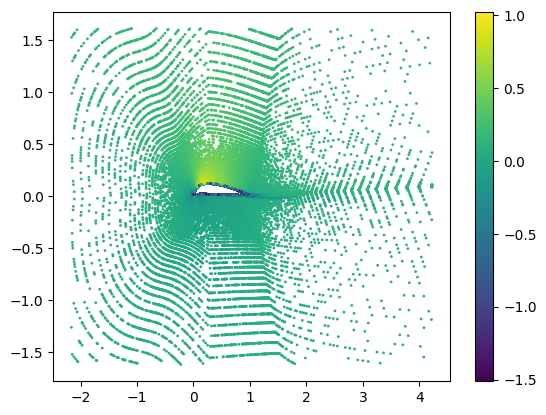

In [44]:
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vx_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_pred_train_2.png', dpi=500)

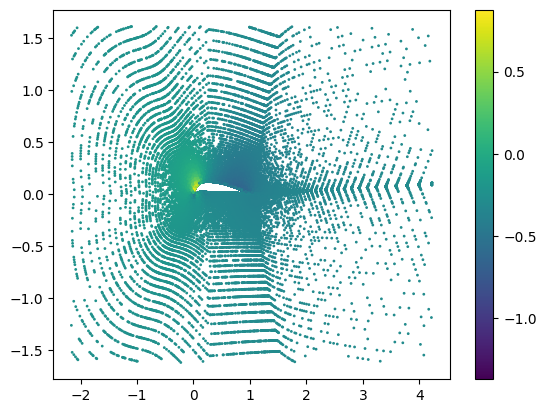

In [45]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vy.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_gt_train_2.png', dpi=500)

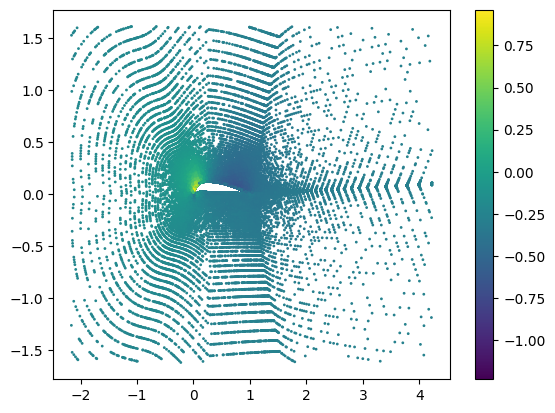

In [46]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vy_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_pred_train_2.png', dpi=500)

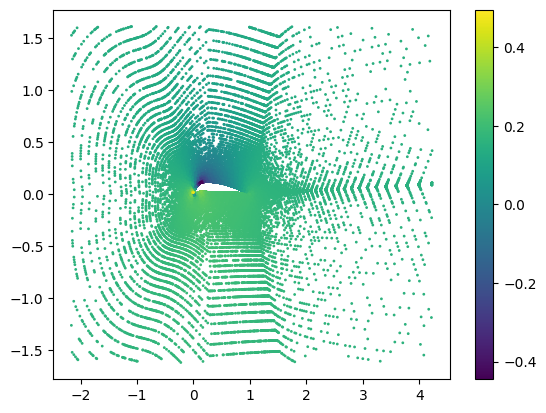

In [47]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.p.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_gt_train_2.png', dpi=500)

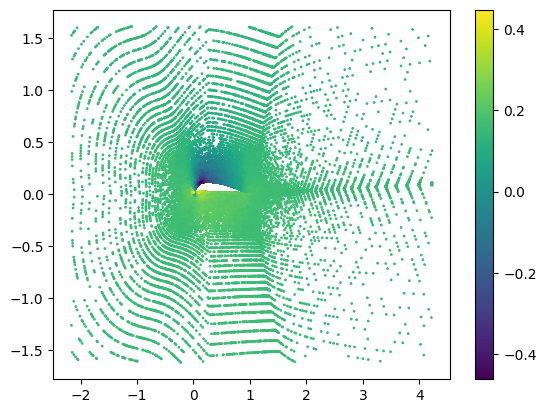

In [48]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=p_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_pred_train_2.png', dpi=500)

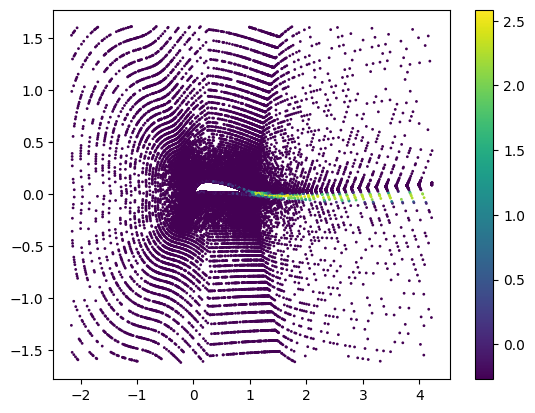

In [49]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.nu.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_gt_train_2.png', dpi=500)

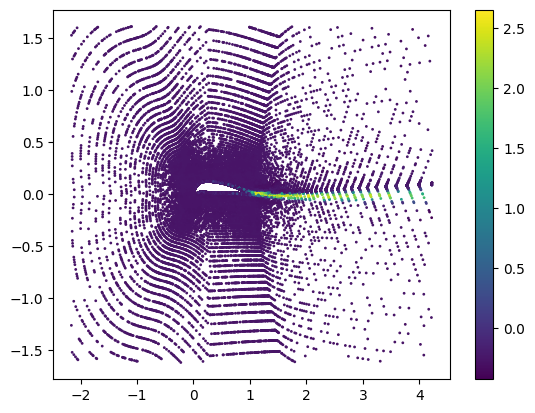

In [50]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=nu_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_pred_train_2.png', dpi=500)

In [18]:
# val results

In [52]:
code_train_mse = 0
code_test_mse = 0
vx_train_mse = 0
vx_test_mse = 0
vy_train_mse = 0
vy_test_mse = 0
p_train_mse = 0
p_test_mse = 0
nu_train_mse = 0
nu_test_mse = 0
step=0
step_show = step % 100 == 0

for substep, (graph, idx) in enumerate(test_loader):
    model.eval()
    graph = graph.cuda()
    n_samples = len(graph)
    
    with torch.no_grad():
        pred = model(graph)
        
    loss = ((pred - graph.z)**2).mean()
    code_test_mse += loss.item() * n_samples

    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    z_pred = pred.reshape(-1, 4, latent_dim)
    z_vx_pred = z_pred[:, 0, :] * sigma_vx + mu_vx
    z_vy_pred = z_pred[:, 1, :] * sigma_vy + mu_vy
    z_p_pred = z_pred[:, 2, :] * sigma_p + mu_p
    z_nu_pred = z_pred[:, 3, :] * sigma_nu + mu_nu

    with torch.no_grad():
        vx_pred = inr_vx.modulated_forward(graph.pos, z_vx_pred[graph.batch])
        vy_pred = inr_vy.modulated_forward(graph.pos, z_vy_pred[graph.batch])
        p_pred = inr_p.modulated_forward(graph.pos, z_p_pred[graph.batch])
        nu_pred = inr_nu.modulated_forward(graph.pos, z_nu_pred[graph.batch])

    vx_test_mse += ((vx_pred - graph.vx)**2).mean().item()*n_samples
    vy_test_mse += ((vy_pred - graph.vy)**2).mean().item()*n_samples
    p_test_mse += ((p_pred - graph.p)**2).mean().item()*n_samples
    nu_test_mse += ((nu_pred - graph.nu)**2).mean().item()*n_samples

code_test_loss = code_test_mse / nval
vx_test_mse = vx_test_mse / nval
vy_test_mse = vy_test_mse / nval
p_test_mse = p_test_mse / nval
nu_test_mse = nu_test_mse / nval
print("test", step, code_test_loss)

test 0 0.0179769051814219


In [29]:
import os
os.makedirs("/home/serrano/Projects/INR_domain_decomposition/experiments/notebooks/plots/")

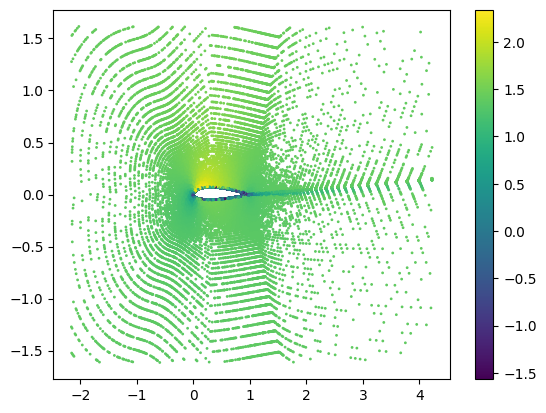

In [53]:
# vx
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vx.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_gt_test_2.png', dpi=500)

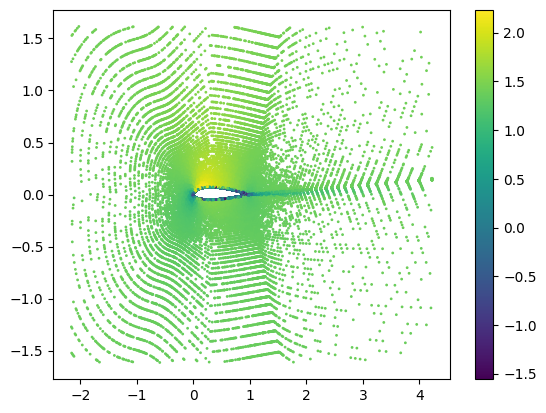

In [54]:
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vx_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vx_pred_test_2.png', dpi=500)

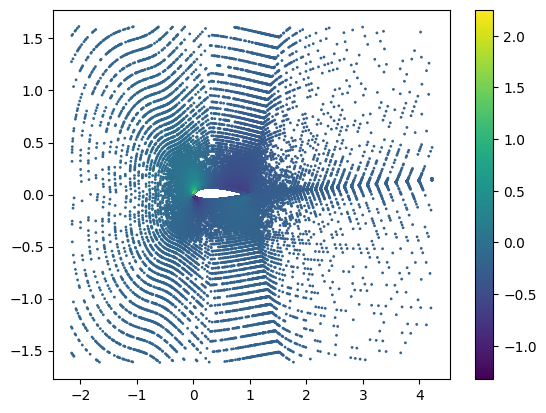

In [55]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.vy.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_gt_test_2.png', dpi=500)

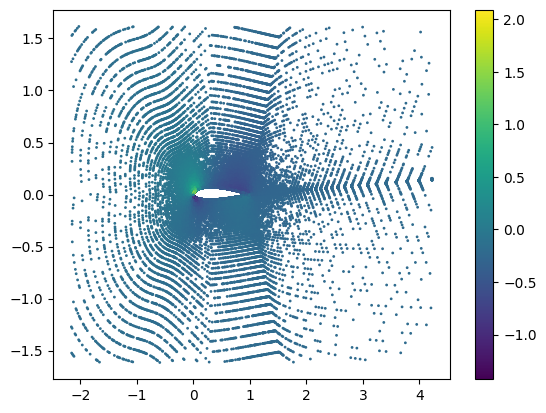

In [56]:
# vy
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=vy_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/vy_pred_test_2.png', dpi=500)

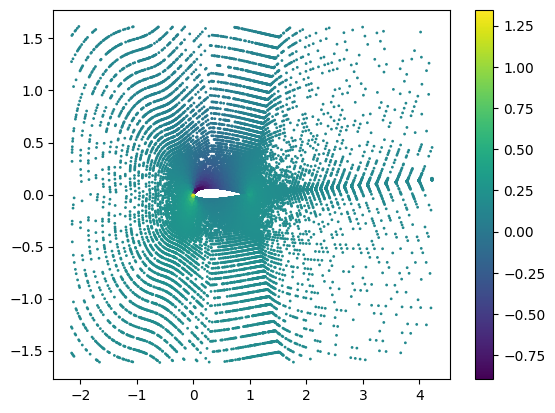

In [57]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.p.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_gt_test_2.png', dpi=500)

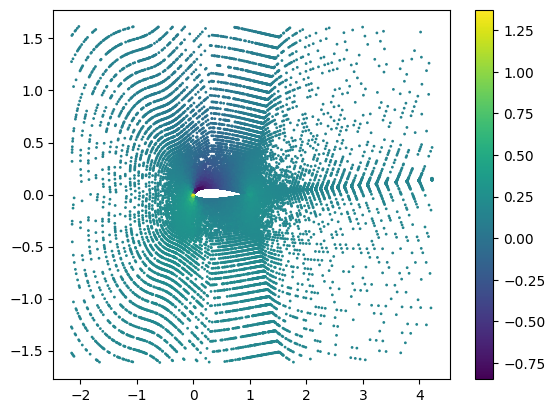

In [58]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=p_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/p_pred_test_2.png', dpi=500)

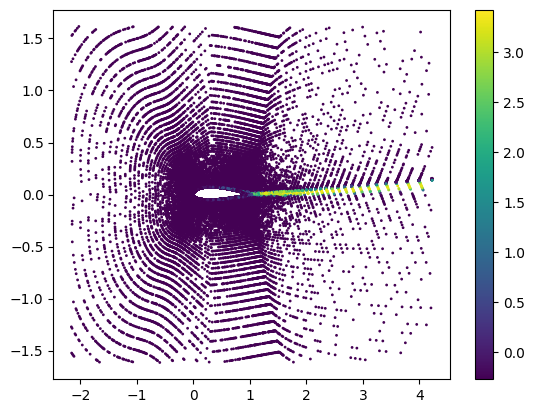

In [59]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=graph.nu.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_gt_test_2.png', dpi=500)

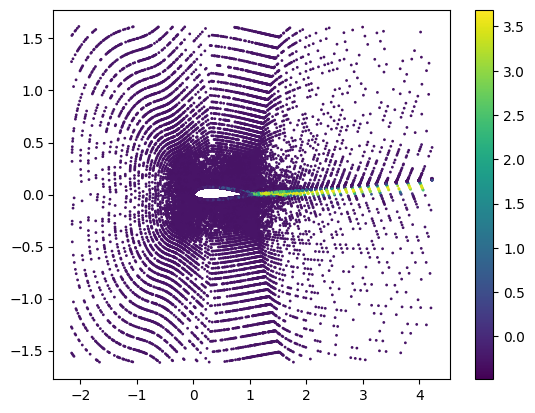

In [60]:
# p
plt.scatter(graph.pos[..., 0].cpu().detach(), graph.pos[..., 1].cpu().detach(), c=nu_pred.cpu().detach(), s=1)
plt.colorbar()
plt.savefig('plots/nu_pred_test_2.png', dpi=500)

In [61]:
vx_test_mse

0.004273039177860483

In [62]:
vy_test_mse

0.005369530408643186

In [63]:
p_test_mse

0.014930243535491172

In [64]:
nu_test_mse

0.01556197827012511

In [65]:
p_pred.shape

torch.Size([64000, 1])